In [19]:
import model
import os
from option import args
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import data
import utils
import numpy as np
import json
import h5py
loaded = {}
loaded_gt ={}

path,tot = "",""


def load_path(base_dir,ids):
    base_dir_7t = [base_dir + "/HCP_7T/" + i   for i in ids]
    base_dir_3t = [base_dir + "/HCP_3T/" + i   for i in ids]
    path_7t = {}
    path_3t = {}
    for i in base_dir_7t:
        path_7t[i[-6:]] = {"h5" : i + "/" + i[-6:] + ".h5"
                        , "GT" : i + "/" + i[-6:] + "_GT.h5"}
    for i in base_dir_3t:
        path_3t[i[-6:]] = {"h5" : i + "/" + i[-6:] + ".h5"
                        , "upsampled" : i + "/" + i[-6:] + "_upsampled.h5"
                        , "GT" : i + "/" + i[-6:] + "_GT.h5"}
    path = {'3T': path_3t, "7T":  path_7t}
    p = list(path_7t.keys())
    q = list(path_3t.keys())
    common = list(set(p) & set(q))

    return path,len(common)

def load_data(base_dir,ids):
    ids.sort()
    path,tot = load_path(base_dir,ids)
    act_ids = []
    for i in ids:
        name = path['3T'][i]['h5']
        if(not os.path.isfile(name)):
            continue
        res_vol = h5py.File(name, 'r')
        
        # print(res_vol.keys())
        loaded[i] = {'vol0':res_vol.get('volumes0')[:]
                            ,'mask':res_vol.get('mask')[:] }
        
        name = path['7T'][i]['GT']
        
        if(not os.path.isfile(name)):
            continue
        res = h5py.File(name, 'r')
        # print(res.keys())
        loaded_gt[i] = {'ADC':res.get('ADC')[:]
                            ,'FA':res.get('FA')[:] 
                            ,'color_FA':res.get('color_FA')[:] }
        
        
        res_vol.close()
        res.close()

        name = path['7T'][i]['h5']
        
        if(not os.path.isfile(name)):
            continue
        res = h5py.File(name, 'r')
        loaded_gt[i]['vol0'] = res.get('volumes0')[:]
        loaded_gt[i]['mask'] = res.get('mask')[:]
        res_vol.close()
        res.close()
        act_ids.append(i)
    return act_ids

In [20]:
load_dir = "working_models"

In [21]:
paths = {}
max_ep = 0
for i in os.listdir(load_dir):
    if "check" not in i and "tensor" not in i:
        temp = []
#         print(os.listdir(load_dir + "/" + i))
        for j in os.listdir(load_dir + "/" + i + "/model"):
            temp.append(load_dir + "/" + i + "/model/" + j)
            
            
            _,ep,hfen,psnr = j.split("_")
            ep = int(ep)
            if(max_ep < ep):
                latest_ep_path = load_dir + "/" + i + "/model/" + j
                max_ep = ep
                
            conf = load_dir + "/" + i + "/config.txt"
        paths[i] = (temp,conf,latest_ep_path) 

In [22]:
list_models = list(paths.keys())

In [23]:
paths

{'dmri_rdn,False,conv,growth128,loss_1*L1,batch_size_8': (['working_models/dmri_rdn,False,conv,growth128,loss_1*L1,batch_size_8/model/model_25_0.5027_19.1527.pt',
   'working_models/dmri_rdn,False,conv,growth128,loss_1*L1,batch_size_8/model/model_3_0.6010_17.7611.pt',
   'working_models/dmri_rdn,False,conv,growth128,loss_1*L1,batch_size_8/model/model_6_0.5281_18.4563.pt',
   'working_models/dmri_rdn,False,conv,growth128,loss_1*L1,batch_size_8/model/model_27_0.4955_19.2090.pt',
   'working_models/dmri_rdn,False,conv,growth128,loss_1*L1,batch_size_8/model/model_7_0.5369_18.4709.pt',
   'working_models/dmri_rdn,False,conv,growth128,loss_1*L1,batch_size_8/model/model_4_0.6004_17.9686.pt',
   'working_models/dmri_rdn,False,conv,growth128,loss_1*L1,batch_size_8/model/model_13_0.5259_18.9297.pt',
   'working_models/dmri_rdn,False,conv,growth128,loss_1*L1,batch_size_8/model/model_58_0.5062_19.3343.pt',
   'working_models/dmri_rdn,False,conv,growth128,loss_1*L1,batch_size_8/model/model_9_0.4964

In [24]:
paths[list_models[0]][2]

'working_models/dmri_rdn,False,conv,growth128,loss_1*L1,batch_size_8/model/model_76_0.5122_19.3765.pt'

In [25]:
paths[list_models[0]][1]

'working_models/dmri_rdn,False,conv,growth128,loss_1*L1,batch_size_8/config.txt'

In [26]:
list_models

['dmri_rdn,False,conv,growth128,loss_1*L1,batch_size_8',
 'dmri_rdn,False,conv,growth32,loss_0.5*MSE+0.5*L1,batch_size_8',
 'dmri_rdn,False,conv,growth64,loss_1*L1,batch_size_8',
 'dmri_rdn,False,conv,growth32,loss_1*L1,batch_size_8,variable_blk_size',
 'dmri_rdn,False,conv,growth32,loss_1*MSE,batch_size_8,variable_blk_size']

In [27]:
load_model = list_models[0]

In [28]:
load_model

'dmri_rdn,False,conv,growth128,loss_1*L1,batch_size_8'

In [29]:
with open(paths[load_model][1], 'r') as f:
    args.__dict__ = json.load(f)

In [30]:
args

Namespace(block_size=[32, 32, 4], var_blk_size=False, start_var=True, epochs=100, dir='/storage', batch_size=8, sort=True, debug=False, preload=True, ret_points=False, enable_thres=True, thres=0.6, rel_coord=False, patience=3, no_vols=10, test_vols=10, lr=0.005, max_lr=0.01, lr_decay=20, decay_type='step', gamma=0.8, optimizer='ADAM', momentum=0.9, beta1=0.9, beta2=0.999, epsilon=1e-08, weight_decay=0, start_epoch=0, loss='1*L1', skip_threshold=1000000.0, run_name='..', save='DTIArb', load='.', save_models=False, resume=0, print_every=20, save_every=30, cpu=False, gpu=0, seed=1, reset=False, pin_mem=False, model='dmri_rdn', in_chans=7, encoder='rdb', tv=False, attention=False, drop_prob=0, growth=128, model_type='3d', out_chans=5, RDNconfig='C', precision='single', cuda=True, scale=[1, 1, 1], offset=3, stable_epoch=1, tv_en=False)

In [31]:
# import json
# with open(paths[list_models[0]][1], 'w') as f:
#     json.dump(args.__dict__, f, indent=2)

In [32]:
curr_model = model.Model(args)
curr_model.load(paths[load_model][2])

Making model... here
load from model_working_models/dmri_rdn,False,conv,growth128,loss_1*L1,batch_size_8/model/model_76_0.5122_19.3765.pt.pt


In [33]:
ids = utils.get_ids()
ids.sort()
offset = 50
total_vols = args.no_vols+args.test_vols
temp = ids[:args.no_vols]
temp.extend(ids[offset:args.test_vols+offset])
ids = temp
print(ids)
args.psnr_sim = 25

['100610', '102311', '102816', '104416', '105923', '108323', '109123', '111312', '111514', '114823', '172130', '173334', '175237', '176542', '177140', '177645', '177746', '178142', '178243', '178647']


### Dataloader

In [34]:
loader = data.Data(args,ids= ids)

Loading Done


In [35]:
len(loader.training_dataset)

54

In [36]:
len(next(iter(loader.training_data)))

4

## ADC

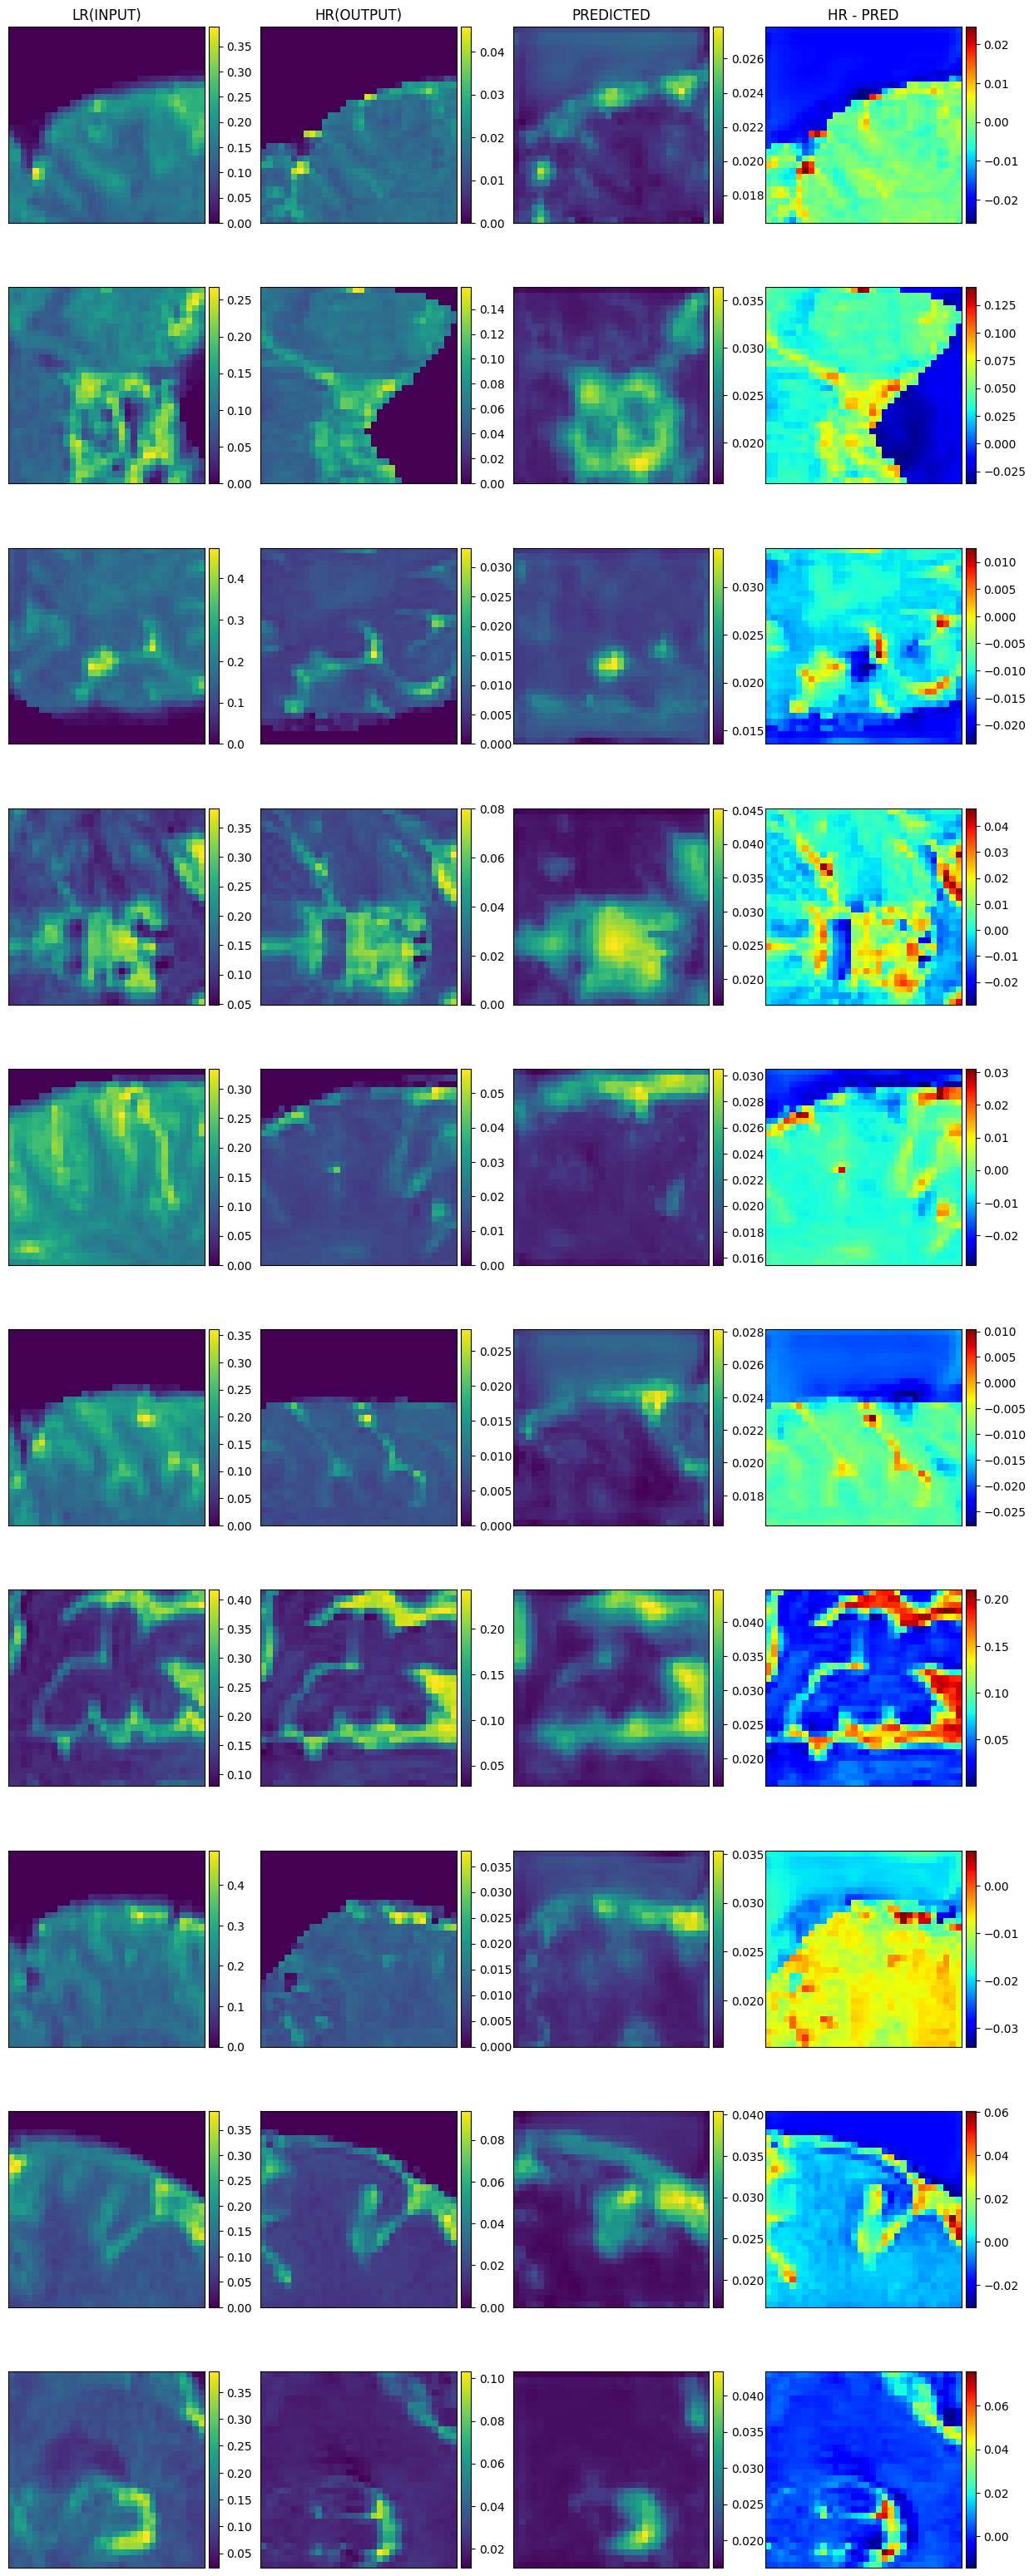

In [37]:
samples = 10
fig, ax = plt.subplots(samples,4)

# to change size of subplot's set height of each subplot as 8
fig.set_figheight(4*samples)
 
# set width of each subplot as 8
fig.set_figwidth(15)
ax[0][0].set_title("LR(INPUT)")
ax[0][1].set_title("HR(OUTPUT)")
ax[0][2].set_title("PREDICTED")
ax[0][3].set_title("HR - PRED")
for i in range(samples):
    temp = next(iter(loader.training_data))
    idx = np.where(np.asarray(temp[0].squeeze().shape[1:-1]) == min(temp[0].squeeze().shape[1:-1]))[0][0]
    buf = {}
    rel_coor = temp[3].squeeze().to('cuda').float()
    
    lr_tensor = torch.permute(temp[0].squeeze(), (0,4,1,2,3)).to('cuda')
    pred = curr_model.forward(lr_tensor,temp[2][0],rel_coor)
    pred = torch.permute(pred, (0,2,3,4,1)).float()
    
#     ax[i][3].set_title(f"{temp[2]}")
    
    buf[2] = pred.cpu().detach().numpy()
    buf[3] = temp[1].squeeze() - buf[2]
    
    
    if idx == 0 :
        buf[0],buf[1] = temp[0].squeeze()[0,0,:,:,0],temp[1].squeeze()[0,0,:,:,0]
        buf[2],buf[3] = buf[2][0,0,:,:,0],buf[3][0,0,:,:,0]
    elif idx == 1:
        buf[0],buf[1] = temp[0].squeeze()[0,:,0,:,0],temp[1].squeeze()[0,:,0,:,0]
        buf[2],buf[3] = buf[2][0,:,0,:,0],buf[3][0,:,0,:,0]
    else:
        buf[0],buf[1] = temp[0].squeeze()[0,:,:,0,0],temp[1].squeeze()[0,:,:,0,0]
        buf[2],buf[3] = buf[2][0,:,:,0,0],buf[3][0,:,:,0,0]
        
    for j in range(4):
#         print(j)
        if(j == 3):
            im = ax[i][j].imshow(buf[j],cmap='jet')
        else:
            im = ax[i][j].imshow(buf[j])
        divider = make_axes_locatable(ax[i][j])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
        ax[i][j].tick_params(left = False, right = False , labelleft = False , 
            labelbottom = False, bottom = False) 
    
        

## FA

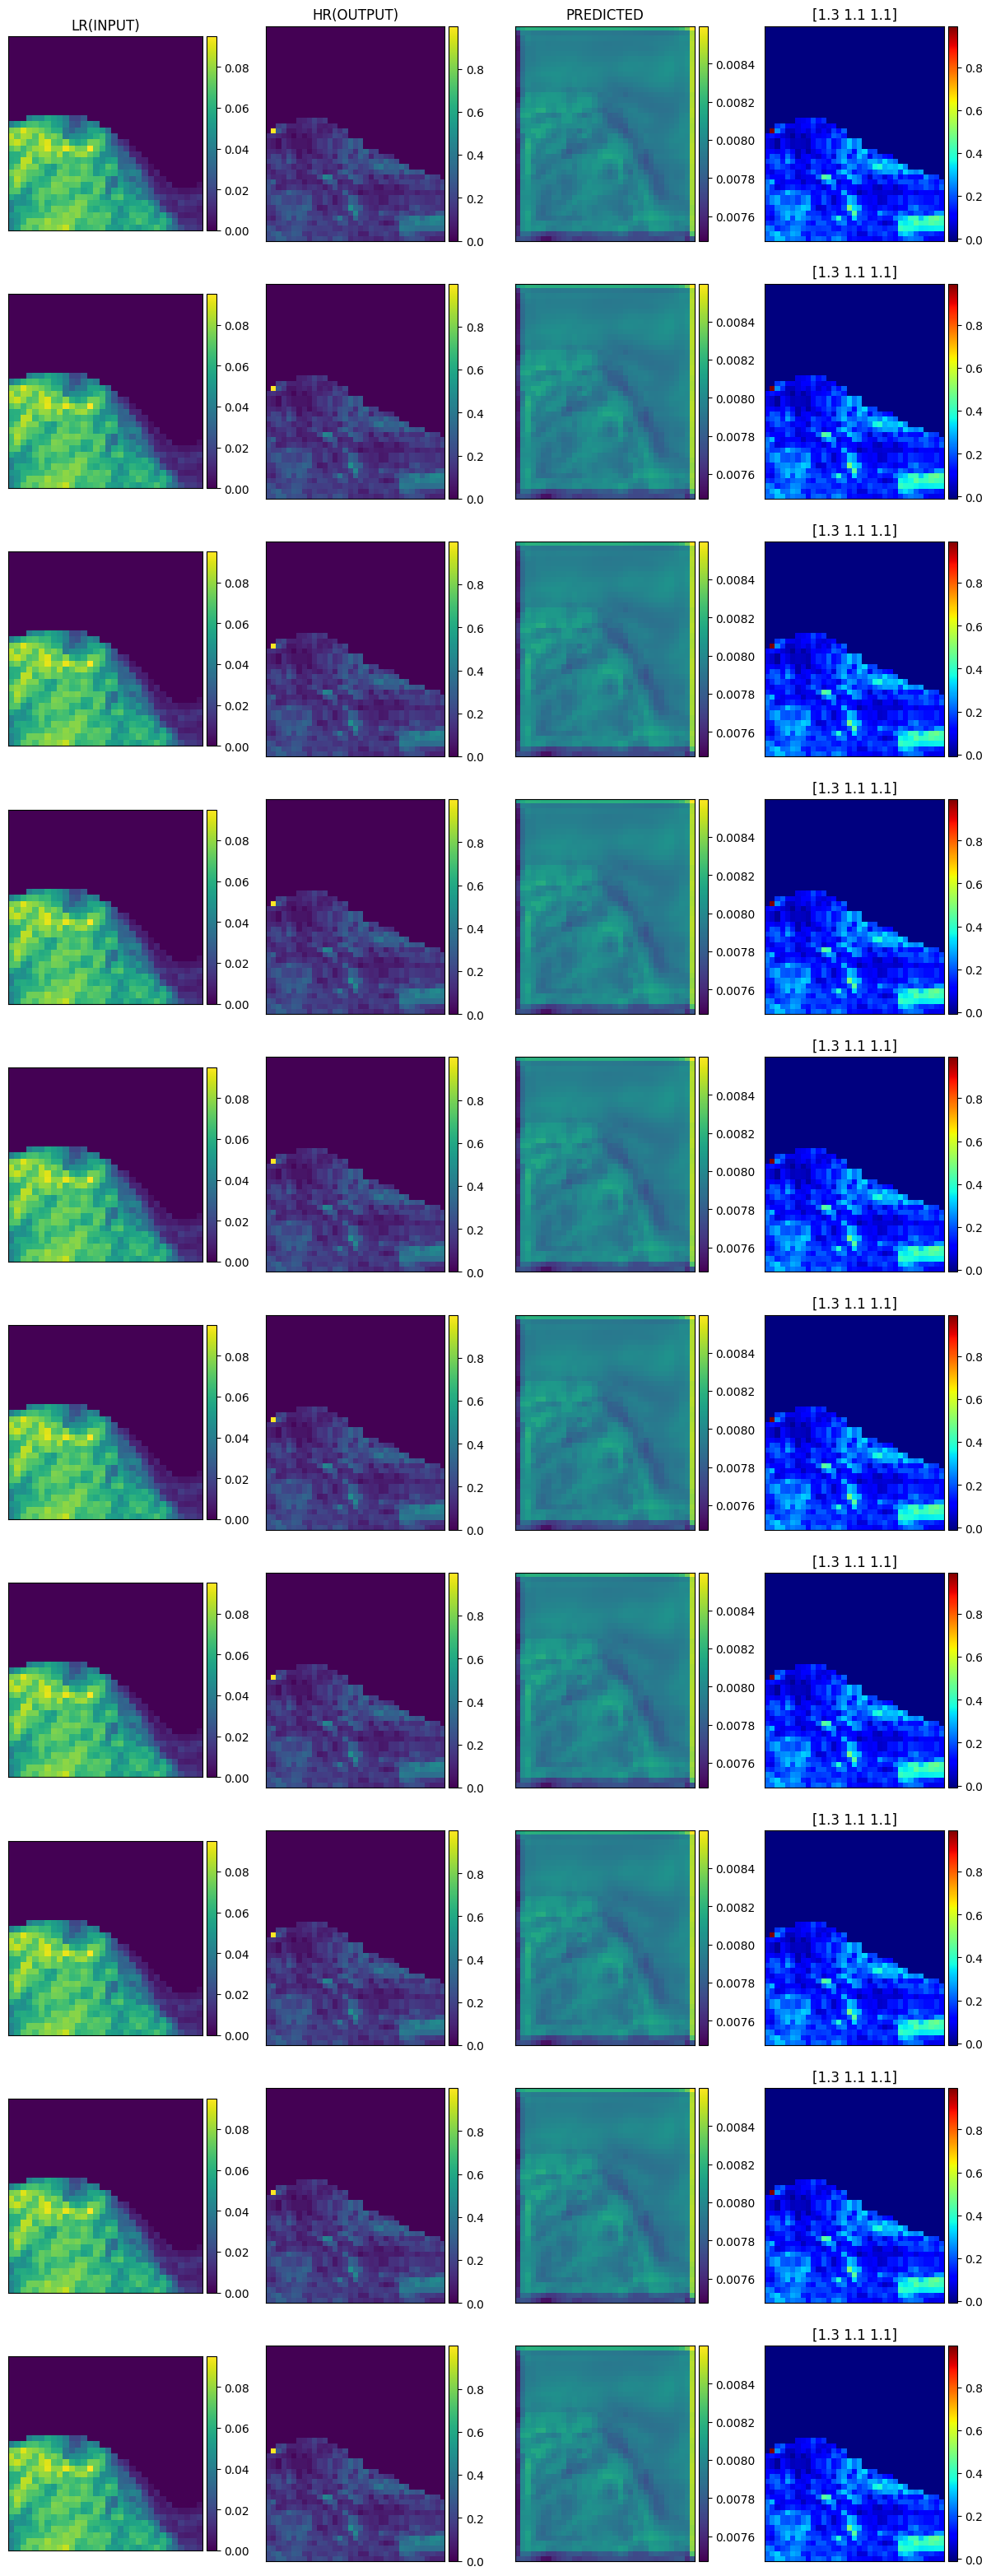

In [20]:
samples = 10
fig, ax = plt.subplots(samples,4)

# to change size of subplot's set height of each subplot as 8
fig.set_figheight(4*samples)
 
# set width of each subplot as 8
fig.set_figwidth(15)
ax[0][0].set_title("LR(INPUT)")
ax[0][1].set_title("HR(OUTPUT)")
ax[0][2].set_title("PREDICTED")
ax[0][3].set_title("HR - PRED")
for i in range(samples):
    temp = next(iter(loader.training_data))
    buf = {}
    buf[0] = temp[0][0,:,:,0,1]
    buf[1] = temp[1][0,:,:,0,1]
    
    lr_tensor = torch.permute(temp[0], (0,4,1,2,3)).to('cuda')
    pred = curr_model.forward(lr_tensor,temp[2])
    pred = torch.permute(pred, (0,2,3,4,1)).float()
    
    ax[i][3].set_title(f"{temp[2]}")
    
    buf[2] = pred[0,:,:,0,1].cpu().detach().numpy()
    buf[3] = temp[1][0,:,:,0,1] - buf[2]
    
    for j in range(4):
        if(j == 3):
            im = ax[i][j].imshow(buf[j],cmap='jet')
        else:
            im = ax[i][j].imshow(buf[j])
        divider = make_axes_locatable(ax[i][j])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
        ax[i][j].tick_params(left = False, right = False , labelleft = False , 
            labelbottom = False, bottom = False) 
    
        

In [21]:
temp[0].shape

torch.Size([1, 32, 32, 8, 7])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

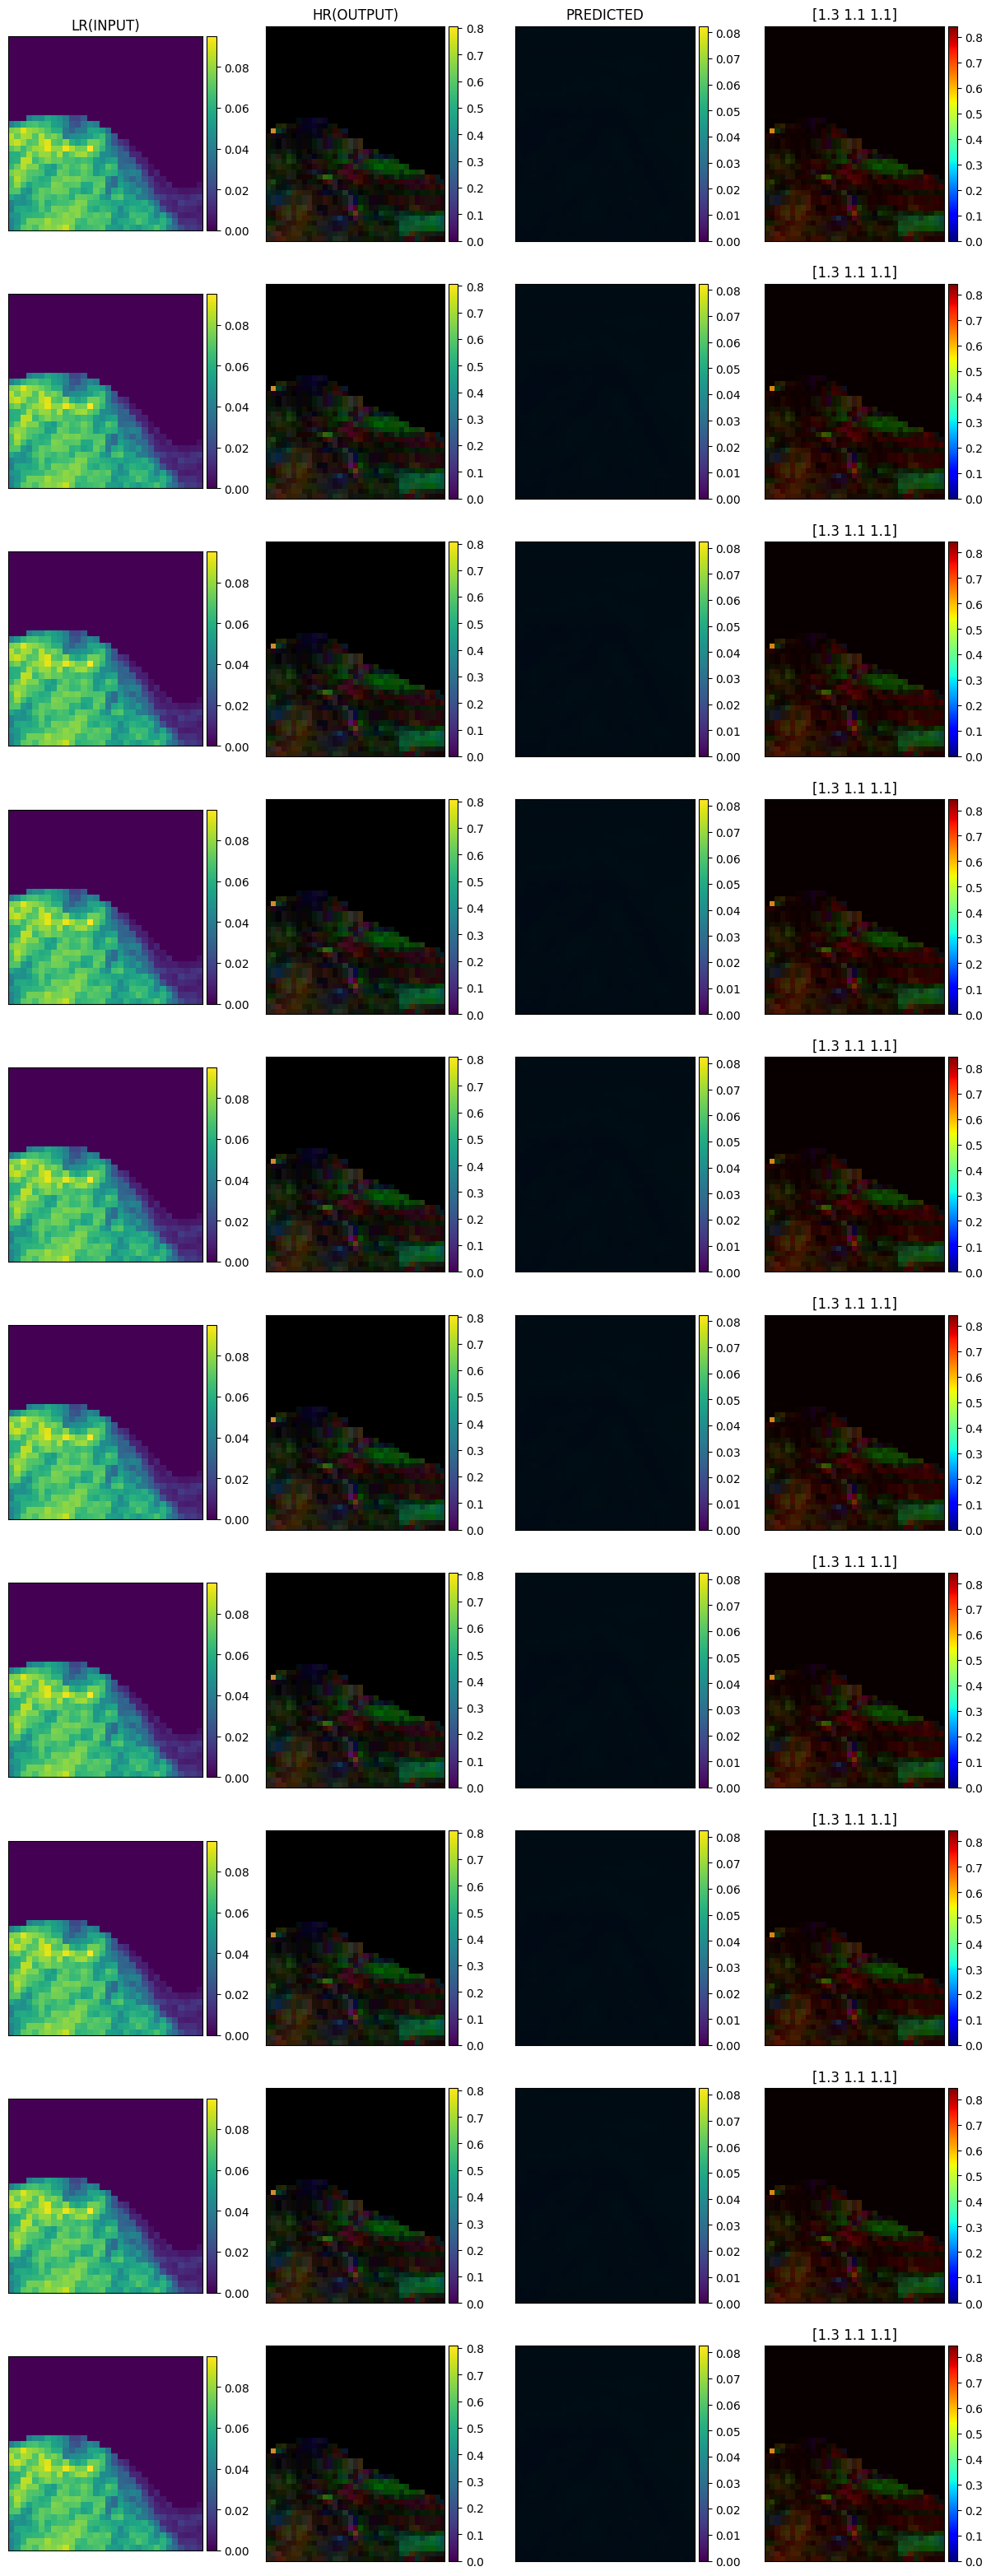

In [22]:
samples = 10
fig, ax = plt.subplots(samples,4)

# to change size of subplot's set height of each subplot as 8
fig.set_figheight(4*samples)
 
# set width of each subplot as 8
fig.set_figwidth(15)
ax[0][0].set_title("LR(INPUT)")
ax[0][1].set_title("HR(OUTPUT)")
ax[0][2].set_title("PREDICTED")
ax[0][3].set_title("HR - PRED")
for i in range(samples):
    temp = next(iter(loader.training_data))
    buf = {}
    buf[0] = temp[0][0,:,:,0,1]
    buf[1] = temp[1][0,:,:,0,2:]
    
    lr_tensor = torch.permute(temp[0], (0,4,1,2,3)).to('cuda')
    pred = curr_model.forward(lr_tensor,temp[2])
    pred = torch.permute(pred, (0,2,3,4,1)).float()
    
    ax[i][3].set_title(f"{temp[2]}")
    
    buf[2] = pred[0,:,:,0,2:].cpu().detach().numpy()
    buf[3] = temp[1][0,:,:,0,2:] - buf[2]
    
    for j in range(4):
        if(j == 3):
            im = ax[i][j].imshow(buf[j],cmap='jet')
        else:
            im = ax[i][j].imshow(buf[j])
        divider = make_axes_locatable(ax[i][j])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
        ax[i][j].tick_params(left = False, right = False , labelleft = False , 
            labelbottom = False, bottom = False) 
    
        

In [105]:
def recon(lr_tensor,hr_tensor,pnts):
    num_blk = lr_tensor.shape[0]
    vol = torch.empty(size=hr_tensor.shape)
    with torch.no_grad():
        for ii in range(num_blk):
            tm = lr_tensor[ii,...]
            tm = tm.unsqueeze(0)
            pred = curr_model.forward(tm,scale)
            pred = torch.permute(pred, (0,2,3,4,1)).float()
            vol[pnts[ii][0]:pnts[ii][1]+1,pnts[ii][2]:pnts[ii][3]+1,pnts[ii][4]:pnts[ii][5]+1,...] = pred[0,...]
    return vol

In [90]:
for iteration, (lr_tensor, hr_tensor,pnts,scale) in enumerate(loader.testing_data, 1):
    lr_tensor = lr_tensor.to('cuda')
    hr_tensor = hr_tensor.to('cuda')
    lr_tensor = torch.permute(lr_tensor, (0,4,1,2,3))
    
    vol = recon(lr_tensor,hr_tensor,pnts)

            
    break

In [91]:
vol.shape

torch.Size([232, 261, 232, 5])

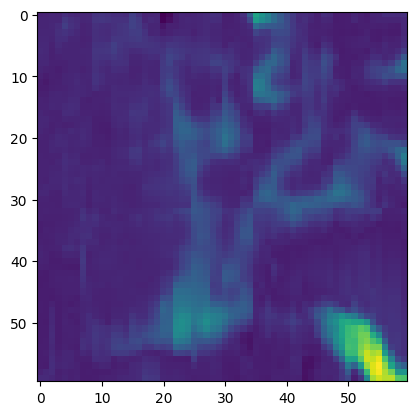

In [22]:
plt.imshow(vol[80,:,:,0][40:100,40:100])

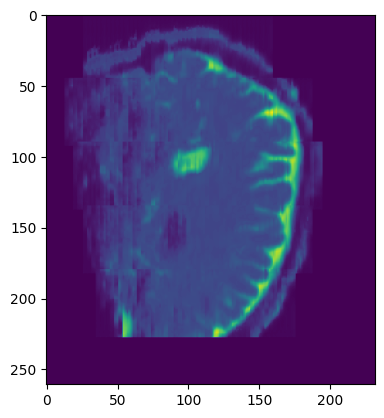

In [92]:
plt.imshow(vol[80,:,:,0])

In [67]:
scale = (1.2,1.2,1.2)
temp = loaded['172130']['vol0']
temp = temp[np.newaxis,...]
temp = torch.from_numpy(temp)

temp = torch.permute(temp, (0,4,1,2,3))
temp = temp.to('cuda')

In [68]:
temp.shape

torch.Size([1, 7, 145, 174, 145])

In [69]:
scale

(1.2, 1.2, 1.2)

In [73]:
loaded_gt['172130']['ADC'].shape

(173, 207, 173, 1)

In [74]:
tmp = temp[:,:,20:84,20:84,60:64]

In [75]:
tmp.shape

torch.Size([1, 7, 64, 64, 4])

In [76]:
scale

(1.2, 1.2, 1.2)

In [82]:
o = curr_model.forward(tmp,scale)
o = torch.permute(o, (0,2,3,4,1)).float()

In [83]:
o.shape

torch.Size([1, 77, 77, 5, 5])

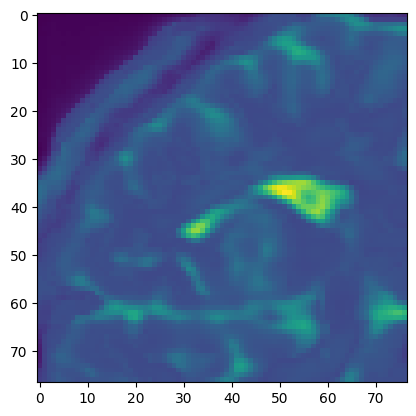

In [84]:
plt.imshow(o[0,:,:,2,0].cpu().detach().numpy())

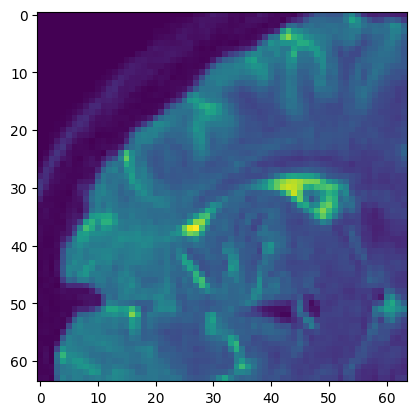

In [88]:
plt.imshow(temp[0,0,20:84,20:84,62].cpu().detach().numpy())

In [86]:
temp[0,0,20:84,20:84,60:64].shape

torch.Size([64, 64, 4])

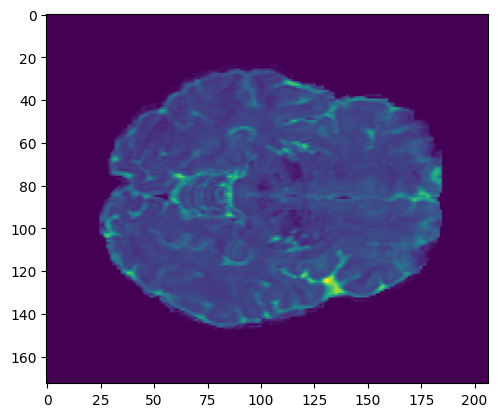

In [80]:
plt.imshow(loaded_gt['172130']['ADC'][:,:,62:63,0])


In [47]:
loaded['172130']

{'vol0': array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
     